# Neural Network Testing Framework

This notebook provides a clean framework for testing trained GCN models on 3-way max-cut problems.

## Features:
- Load trained neural network models
- Generate and process test graphs
- Compare GCN performance with and without post-processing
- Comprehensive performance analysis across multiple graph sizes
- Visualization of results

**Core functionality is implemented in `Testing/TestingNeuralNetwork.py`**

## Setup and Imports

In [1]:
import sys
import os
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from time import time
import random
import matplotlib.pyplot as plt

# Add the current directory to Python path for imports
current_dir = Path.cwd()
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))
if str(current_dir.parent) not in sys.path:
    sys.path.append(str(current_dir.parent))

# Import our custom modules
from DataGenerator.GraphCreator import generate_graph, generate_unique_terminals
from DataGenerator.graphExtender import process_graphs_from_folder
from Training.TrainingNeural import TrainingConfig, load_neural_model, evaluate_model
from commons import save_object, open_file

# Import the neural network testing module
from Testing.TestingNeuralNetwork import (
    test_multiple_graphs,
    analyze_results,
    print_analysis_report,
    create_visualizations,
    save_results,
    generate_summary_report
)

print("All modules imported successfully!")
print(f"Current working directory: {current_dir}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All modules imported successfully!
Current working directory: /Users/javaad/Documents/research/GCN-max-cut/python
PyTorch version: 2.7.1
CUDA available: False


## Configuration

In [3]:
# Testing configuration
TESTING_CONFIG = {
    'model_path': './final_maxcut_3way_n500_d6_8_t300_model.pth',  # Path to trained model
    'output_directory': './neural_testing_results',
    'max_nodes': 1000,  # Extended matrix size (should match training)
    'graph_sizes': [50, 100, 200, 300, 500],  # Different graph sizes to test
    'graphs_per_size': 10,  # Number of graphs to test per size
    'degree_range': (6, 8),  # Degree range for test graphs
    'num_terminals': 3,  # 3-way max-cut
    'post_processing_iterations': 200  # Iterations for post-processing optimization
}

# Model configuration (should match training configuration)
MODEL_CONFIG = TrainingConfig(
    n_nodes=TESTING_CONFIG['max_nodes'],
    dim_embedding=TESTING_CONFIG['max_nodes'],
    hidden_dim=TESTING_CONFIG['max_nodes'] // 2,
    dropout=0.0,
    number_classes=3,
    learning_rate=0.001,
    number_epochs=1000,
    tolerance=1e-4,
    patience=20,
    A=0.0,
    C=1.0,
    penalty=1000.0
)

# Create output directory
os.makedirs(TESTING_CONFIG['output_directory'], exist_ok=True)

print("Configuration:")
for key, value in TESTING_CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  model_path: ./final_maxcut_3way_n500_d6_8_t300_model.pth
  output_directory: ./neural_testing_results
  max_nodes: 1000
  graph_sizes: [50, 100, 200, 300, 500]
  graphs_per_size: 10
  degree_range: (6, 8)
  num_terminals: 3
  post_processing_iterations: 200


## Load Trained Neural Network

In [4]:
print("Loading trained neural network...")
print(f"Model path: {TESTING_CONFIG['model_path']}")

try:
    # Fix for PyTorch 2.6+ loading issues
    import torch.serialization
    from Training.TrainingNeural import TrainingConfig
    torch.serialization.add_safe_globals([TrainingConfig])
    
    # Load the trained model
    trained_model, model_inputs, loaded_config = load_neural_model(
        TESTING_CONFIG['model_path'], 
        MODEL_CONFIG
    )
    
    trained_model.eval()  # Set to evaluation mode
    
    print("✓ Neural network loaded successfully")
    print(f"  Model parameters: {sum(p.numel() for p in trained_model.parameters()):,}")
    print(f"  Architecture: {MODEL_CONFIG.dim_embedding} -> {MODEL_CONFIG.hidden_dim} -> {MODEL_CONFIG.number_classes}")
    print(f"  Device: {next(trained_model.parameters()).device}")
    
except Exception as e:
    print(f"✗ Failed to load neural network: {e}")
    raise

Loading trained neural network...
Model path: ./final_maxcut_3way_n500_d6_8_t300_model.pth
✓ Neural network loaded successfully
  Model parameters: 502,003
  Architecture: 1000 -> 500 -> 3
  Device: cpu


## Generate Test Graphs

In [6]:
print("Generating test graphs...")

all_test_graphs = {}
all_test_terminals = {}
generation_times = {}

for graph_size in TESTING_CONFIG['graph_sizes']:
    print(f"\nGenerating {TESTING_CONFIG['graphs_per_size']} graphs with {graph_size} nodes...")
    
    size_start_time = time()
    graphs_for_size = {}
    terminals_for_size = {}
    
    for i in range(TESTING_CONFIG['graphs_per_size']):
        # Random degree within specified range
        degree = random.randint(*TESTING_CONFIG['degree_range'])
        
        # Generate graph with unique seed
        graph = generate_graph(
            n=graph_size,
            d=degree,
            graph_type='reg',
            random_seed=graph_size * 1000 + i,  # Unique seed
            edge_weight=1,
            edge_capacity=1
        )
        
        # Generate terminal nodes
        terminals = generate_unique_terminals(
            graph_size,
            TESTING_CONFIG['num_terminals']
        )
        
        # Store with descriptive naming
        graph_name = f"test_n{graph_size}_d{degree}_i{i:02d}"
        graphs_for_size[graph_name] = graph
        terminals_for_size[graph_name] = terminals
    
    size_time = time() - size_start_time
    generation_times[graph_size] = size_time
    
    all_test_graphs.update(graphs_for_size)
    all_test_terminals.update(terminals_for_size)
    
    print(f"  Generated {len(graphs_for_size)} graphs in {size_time:.2f}s")

total_graphs = len(all_test_graphs)
total_time = sum(generation_times.values())

print(f"\nGraph generation completed:")
print(f"  Total graphs: {total_graphs}")
print(f"  Total time: {total_time:.2f}s")
print(f"  Average time per graph: {total_time/total_graphs:.4f}s")

Generating test graphs...

Generating 10 graphs with 50 nodes...
  Generated 10 graphs in 0.01s

Generating 10 graphs with 100 nodes...
  Generated 10 graphs in 0.02s

Generating 10 graphs with 200 nodes...
  Generated 10 graphs in 0.03s

Generating 10 graphs with 300 nodes...
  Generated 10 graphs in 0.04s

Generating 10 graphs with 500 nodes...
  Generated 10 graphs in 0.07s

Graph generation completed:
  Total graphs: 50
  Total time: 0.17s
  Average time per graph: 0.0034s


## Process Graphs with GraphExtender

In [7]:
print("Processing graphs with GraphExtender...")
processing_start_time = time()

# Process all test graphs to make them compatible with the neural network
processed_test_graphs = process_graphs_from_folder(
    all_graphs=all_test_graphs,
    all_terminals=all_test_terminals,
    max_nodes=TESTING_CONFIG['max_nodes'],
    save_batch_size=None,  # Don't save batches for testing
    output_filename_prefix="neural_test_processed"
)

processing_time = time() - processing_start_time

print(f"Graph processing completed:")
print(f"  Processed graphs: {len(processed_test_graphs)}")
print(f"  Processing time: {processing_time:.2f}s")
print(f"  Average time per graph: {processing_time/len(processed_test_graphs):.4f}s")

# Analyze processed dataset
sample_key = list(processed_test_graphs.keys())[0]
dgl_graph, adjacency_matrix, nx_graph, terminals = processed_test_graphs[sample_key]

print(f"\nSample processed graph structure:")
print(f"  DGL graph nodes: {dgl_graph.number_of_nodes()}")
print(f"  DGL graph edges: {dgl_graph.number_of_edges()}")
print(f"  Adjacency matrix shape: {adjacency_matrix.shape}")
print(f"  Terminals: {terminals}")

# Save processed graphs for later use
processed_file = os.path.join(TESTING_CONFIG['output_directory'], 'processed_test_graphs.pkl')
save_object(processed_test_graphs, processed_file)
print(f"\nProcessed graphs saved to: {processed_file}")

Processing graphs with GraphExtender...
Terminal swapped 0
Graph finished: 1
Terminal swapped 1
Graph finished: 2
Terminal swapped 2
Graph finished: 3
Terminal swapped 3
Graph finished: 4
Terminal swapped 4
Graph finished: 5
Terminal swapped 5
Graph finished: 6
Terminal swapped 6
Graph finished: 7
Terminal swapped 7
Graph finished: 8
Terminal swapped 8
Graph finished: 9
Terminal swapped 9
Graph finished: 10
Terminal swapped 10
Graph finished: 11
Terminal swapped 11
Graph finished: 12
Terminal swapped 12
Graph finished: 13
Terminal swapped 13
Graph finished: 14
Terminal swapped 14
Graph finished: 15
Terminal swapped 15
Graph finished: 16
Terminal swapped 16
Graph finished: 17
Terminal swapped 17
Graph finished: 18
Terminal swapped 18
Graph finished: 19
Terminal swapped 19
Graph finished: 20
Terminal swapped 20
Graph finished: 21
Terminal swapped 21
Graph finished: 22
Terminal swapped 22
Graph finished: 23
Terminal swapped 23
Graph finished: 24
Terminal swapped 24
Graph finished: 25
Term

## Neural Network Testing

Test the neural network with and without post-processing using the `TestingNeuralNetwork` module

In [8]:
# Run comprehensive testing using the module
test_results, results_by_size = test_multiple_graphs(
    model=trained_model,
    processed_graphs=processed_test_graphs,
    graph_sizes=TESTING_CONFIG['graph_sizes'],
    post_processing_iterations=TESTING_CONFIG['post_processing_iterations'],
    verbose=True
)

Testing neural network performance...
Sample keys from processed_graphs: [0, 1, 2]
\nProcessing graph 1/50: graph_0
  Nodes: 50, Edges: 175, Size category: 50
  Simple GCN:      Cut = 35, Time = 0.0002s
  Post-processed:  Cut = 53, Time = 0.0356s
  Improvement:     +18 (+51.4%)
\nProcessing graph 2/50: graph_1
  Nodes: 50, Edges: 200, Size category: 50
  Simple GCN:      Cut = 47, Time = 0.0002s
  Post-processed:  Cut = 63, Time = 0.0293s
  Improvement:     +16 (+34.0%)
\nProcessing graph 3/50: graph_2
  Nodes: 50, Edges: 150, Size category: 50
  Simple GCN:      Cut = 60, Time = 0.0001s
  Post-processed:  Cut = 67, Time = 0.0245s
  Improvement:     +7 (+11.7%)
\nProcessing graph 4/50: graph_3
  Nodes: 50, Edges: 175, Size category: 50
  Simple GCN:      Cut = 72, Time = 0.0002s
  Post-processed:  Cut = 79, Time = 0.0257s
  Improvement:     +7 (+9.7%)
\nProcessing graph 5/50: graph_4
  Nodes: 50, Edges: 200, Size category: 50
  Simple GCN:      Cut = 62, Time = 0.0001s
  Post-processed

## Performance Analysis and Results

In [9]:
# Analyze the results
analysis = analyze_results(
    test_results=test_results,
    results_by_size=results_by_size,
    graph_sizes=TESTING_CONFIG['graph_sizes']
)

# Print comprehensive analysis report
print_analysis_report(analysis, TESTING_CONFIG['graph_sizes'])

# Save detailed results
results_file = os.path.join(TESTING_CONFIG['output_directory'], 'neural_network_test_results.pkl')
save_results(
    test_results=test_results,
    results_by_size=results_by_size,
    analysis=analysis,
    testing_config=TESTING_CONFIG,
    model_config=MODEL_CONFIG,
    output_file=results_file
)

Performance Analysis
Overall Results (50 graphs):

Cut Value Performance:
  Simple GCN Average:     547.14
  Post-processed Average: 565.16
  Average Improvement:    +18.02 (+6.9%)
  Std Dev Improvement:    9.29

Improvement Distribution:
  Post-processing better: 50/50 (100.0%)
  Same performance:       0/50 (0.0%)
  Post-processing worse:  0/50 (0.0%)

Runtime Performance:
  Simple GCN Average:     0.0003s
  Post-processed Average: 0.1173s
  Runtime Overhead:       374.4x
\n============================================================
Results by Graph Size:
Size   Count  Simple   Post     Improvement  Runtime   
------ ------ -------- -------- ------------ ----------
50     10     59.1     69.4     +17.4  %     185.5 x
100    10     222.2    235.3    +5.9   %     290.2 x
200    10     498.5    517.1    +3.7   %     359.6 x
300    10     724.8    743.4    +2.6   %     410.2 x
500    10     1231.1   1260.6   +2.4   %     426.8 x
Detailed results saved to: ./neural_testing_results/neural

## Visualization

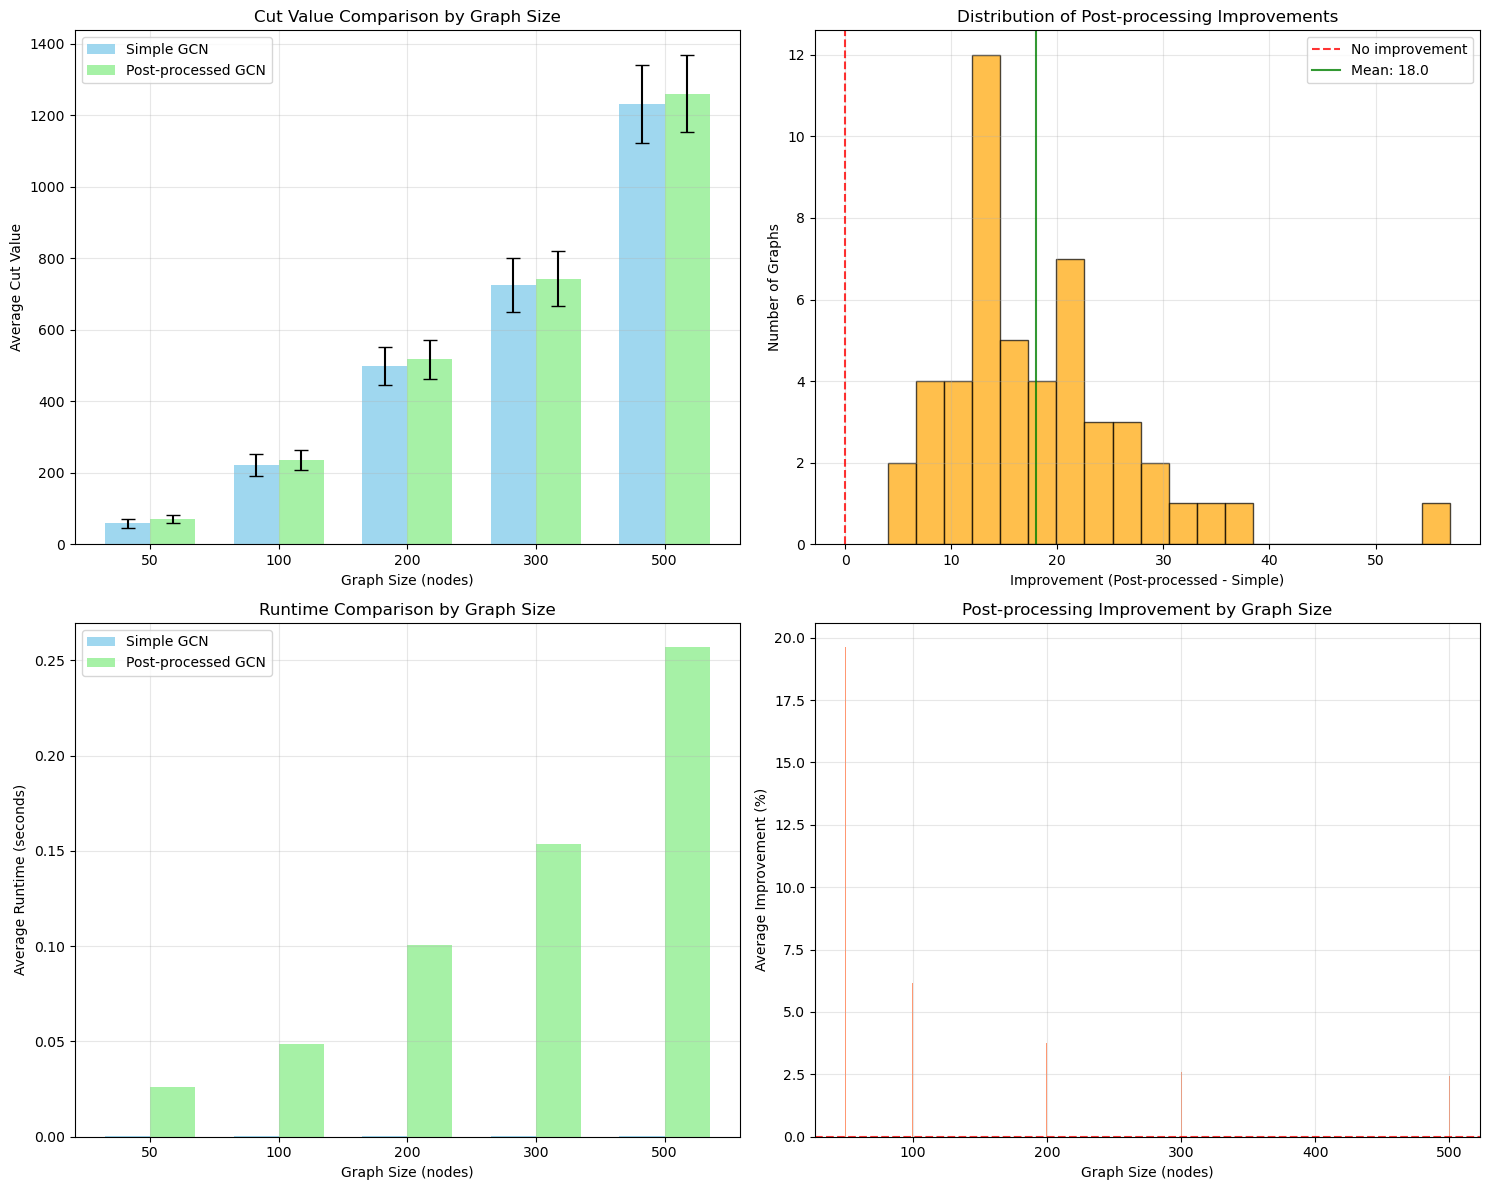

Visualization saved to: ./neural_testing_results/neural_network_analysis.png


<Figure size 640x480 with 0 Axes>

In [10]:
# Create comprehensive visualizations
plot_file = os.path.join(TESTING_CONFIG['output_directory'], 'neural_network_analysis.png')
create_visualizations(
    test_results=test_results,
    results_by_size=results_by_size,
    graph_sizes=TESTING_CONFIG['graph_sizes'],
    save_path=plot_file
)

## Summary Report

In [11]:
# Generate and display comprehensive summary report
summary_report = generate_summary_report(analysis, TESTING_CONFIG)
print(summary_report)

# Save summary report to file
summary_file = os.path.join(TESTING_CONFIG['output_directory'], 'summary_report.txt')
with open(summary_file, 'w') as f:
    f.write(summary_report)
    
print(f"\nSummary report saved to: {summary_file}")
print(f"All results saved to: {TESTING_CONFIG['output_directory']}")

Neural Network Testing Summary

Testing completed on 50 graphs across 5 different sizes.

Key Findings:

1. Post-processing Effectiveness:
   - Improved results in 50/50 cases (100.0%)
   - Average improvement: +18.02 cut value (+6.9%)
   - Standard deviation: 9.29

2. Computational Cost:
   - Post-processing adds 374.4x runtime overhead
   - Simple GCN: 0.0003s average
   - Post-processed: 0.1173s average

3. Scalability:\n   - 50 nodes (10 graphs): +17.4% improvement\n   - 100 nodes (10 graphs): +5.9% improvement\n   - 200 nodes (10 graphs): +3.7% improvement\n   - 300 nodes (10 graphs): +2.6% improvement\n   - 500 nodes (10 graphs): +2.4% improvement

Recommendations:\n✓ Post-processing shows positive results on average\n✓ Post-processing improves results in most cases - recommended\n⚠ High computational overhead (374.4x) - consider cost vs benefit

Configuration Used:
  Model: ./final_maxcut_3way_n500_d6_8_t300_model.pth
  Post-processing iterations: 200
  Graph sizes tested: [50, 

## Optional: Quick Single Graph Test

Test a single graph for debugging or detailed analysis

In [12]:
# Optional: Test a single graph for detailed analysis
from Testing.TestingNeuralNetwork import test_single_graph

# Get a sample graph
sample_key = list(processed_test_graphs.keys())[0]
dgl_graph, adjacency_matrix, nx_graph, terminals = processed_test_graphs[sample_key]

print(f"Testing single graph: {sample_key}")
print(f"Graph properties: {len(nx_graph.nodes())} nodes, {len(nx_graph.edges())} edges")

# Test the single graph
single_result = test_single_graph(
    model=trained_model,
    dgl_graph=dgl_graph,
    adjacency_matrix=adjacency_matrix,
    nx_graph=nx_graph,
    terminals=terminals,
    post_processing_iterations=TESTING_CONFIG['post_processing_iterations']
)

if single_result['success']:
    print(f"\nSingle Graph Results:")
    print(f"  Simple GCN: {single_result['simple_cut']} (time: {single_result['simple_time']:.4f}s)")
    print(f"  Post-processed: {single_result['post_cut']} (time: {single_result['post_time']:.4f}s)")
    print(f"  Improvement: {single_result['improvement']:+d} ({single_result['improvement_percent']:+.1f}%)")
    print(f"  Terminals: {single_result['terminals']}")
    
    # Show probability distributions for first few nodes
    probs = single_result['node_probabilities']
    print(f"\nNode probability distributions (first 6 nodes):")
    for i in range(min(6, len(probs))):
        prob_str = ", ".join([f"{p:.3f}" for p in probs[i]])
        print(f"  Node {i}: [{prob_str}]")
else:
    print(f"Single graph test failed: {single_result['error']}")

Testing single graph: 0
Graph properties: 50 nodes, 175 edges

Single Graph Results:
  Simple GCN: 35 (time: 0.0002s)
  Post-processed: 53 (time: 0.0262s)
  Improvement: +18 (+51.4%)
  Terminals: [0, 1, 2]

Node probability distributions (first 6 nodes):
  Node 0: [0.000, 0.000, 1.000]
  Node 1: [0.123, 0.389, 0.488]
  Node 2: [0.000, 0.000, 1.000]
  Node 3: [0.000, 0.000, 1.000]
  Node 4: [0.000, 0.000, 1.000]
  Node 5: [0.000, 0.000, 1.000]
